In [133]:
import requests
from datetime import date
import datetime
from datetime import datetime  
from datetime import timedelta  
import dateutil.parser
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
%matplotlib inline
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [134]:
## Time horizon D+x for making regression predictions
Prediction_Horizon = 14
## Starting point for minimal number of confirmed cases
Min_Confirmed = 10

In [135]:
url = 'https://data.humdata.org/hxlproxy/data/download/time_series_covid19_confirmed_global_narrow.csv?dest=data_edit&filter01=explode&explode-header-att01=date&explode-value-att01=value&filter02=rename&rename-oldtag02=%23affected%2Bdate&rename-newtag02=%23date&rename-header02=Date&filter03=rename&rename-oldtag03=%23affected%2Bvalue&rename-newtag03=%23affected%2Binfected%2Bvalue%2Bnum&rename-header03=Value&filter04=clean&clean-date-tags04=%23date&filter05=sort&sort-tags05=%23date&sort-reverse05=on&filter06=sort&sort-tags06=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv'
myfile = requests.get(url)
open(r'C:\Users\JMSch\Desktop\COVID19\Data\time_series_covid19_confirmed_global_narrow(all).csv', 'wb').write(myfile.content)

776060

In [136]:
data = pd.read_csv(r'C:\Users\JMSch\Desktop\COVID19\Data\time_series_covid19_confirmed_global_narrow(all).csv', sep = ',')
data = data[1:]

## Choosing the columns for later use
data = data.filter(['Country/Region', 'Date', 'Value'])
## Renaming the columns we are going to use
data.columns = ['Country', 'Date', 'Value']
## Transforming the value to int
data['Value'] = data['Value'].astype(int)
data['Date'] = data['Date'].astype('datetime64[D]')
## Summing values for 'Value' for which there are multiple records for one coutry on one day
data['Total'] = data.groupby(['Country', 'Date'])['Value'].transform('sum')
## Delete the duplicate records
data = data.drop_duplicates(subset=['Country', 'Date'])
## Sort the value from earliest to latest
data = data.sort_values(['Date'], ascending = True)
data.columns = ['Country', 'Date', 'Value', 'Confirmed']

In [137]:
## Remove the dates of which no infections were reported
data = data[data.Confirmed > Min_Confirmed]

## Assign a t value to each date from the first reported infection
#data.insert(loc=0, column='Time', value=np.arange(len(data))+1)

## Transform the date from Excel numbers to Python dates
#data['Date'] = data['Date'].apply(lambda x: x -2)
data['Date'] = data['Date'].astype('datetime64[D]') 
data['Date'] = data['Date'].dt.strftime('%d/%m/2020')

In [138]:
data['Time'] = 1
data = data.sort_values(by=['Country', 'Confirmed'])
data.index = range(len(data))

for index, row in data.iloc[1:].iterrows():
    if data.loc[index, 'Country'] == data.loc[(int(index) - 1), 'Country']: 
        data_new = data[data.Country.eq(data.loc[index, 'Country'])]
        HighestForCountry = data_new['Time'].max()
        data.loc[index, 'Time'] = HighestForCountry + 1
    else:
        data.loc[index, 'Time'] = 1

In [139]:
Countries = data['Country'].tolist()
Countries = list(dict.fromkeys(Countries))

In [140]:
today = date.today()
## Selecting the timeframe for building the regression
LastWeek = today - timedelta(days=Days) 
LastWeek = LastWeek.strftime("%d/%m/%Y")


In [141]:
Full_Data = pd.DataFrame()

## For each country, find the 'Time' reference since patient 1, and the corrsponding date
for Country in Countries:
    data_sub = data[data['Country'].eq(Country)]
    Current_Horizon = int(max(data_sub['Time']))
    FindDate = data_sub['Date'].iloc[-1]
    MaxDate = dateutil.parser.parse(FindDate).date()

## For each country, add the number of days to the prediction horizon of the dataset based on the 'Time' reference and date
    for i in range(Prediction_Horizon):
        New_Time = int(max(data_sub['Time'])) + 1
        Days_Delay = (New_Time - Current_Horizon)
        New_Date = MaxDate + timedelta(days=Days_Delay) 
        New_Date = New_Date.strftime("%d/%m/%Y")
        data_sub = data_sub.append({'Country': Country,'Date': New_Date, 'Time': New_Time},ignore_index=True)
    Full_Data = pd.concat([Full_Data,data_sub]) 


In [142]:
def Polynomial_Regression(t):
    return pol_reg.predict(poly_reg.fit_transform([[t]]))

In [143]:
#Countries = ['Afghanistan']

In [144]:
## building the model per country
Pred_Data = pd.DataFrame()

for Country in Countries:
    data_cntry = Full_Data[Full_Data.Country.eq(Country)]
    if data_cntry.count(axis='columns').count() > 8:
        try:
            Model_Data = data_cntry.dropna()
            Model_Data = Model_Data[['Time','Confirmed']]

            X = Model_Data[['Time']]
            y = Model_Data[['Confirmed']]

            X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

            #lin_reg = LinearRegression()
            #lin_reg.fit(X, y)

            poly_reg = PolynomialFeatures(degree=4)
            X_poly = poly_reg.fit_transform(X)
            pol_reg = LinearRegression()
            pol_reg.fit(X_poly, y)

            ## This code transforms the regression coefficients into floats to use in our prediction function

            data_cntry.insert(5,'Predictions',0)
            data_cntry['Predictions'] = data_cntry['Time'].apply(Polynomial_Regression)
            
            ## remove first set of square brackets from prediciton output
            data_cntry['Predictions'] = data_cntry['Predictions'].str[0]
            ## remove second set of square brackets from prediciton output
            data_cntry['Predictions'] = data_cntry['Predictions'].str[0]
            ## 
            data_cntry['Predictions'] =  data_cntry['Predictions'].astype(float)

            Pred_Data = pd.concat([Pred_Data,data_cntry]) 
        except:
            continue

    else:
            continue


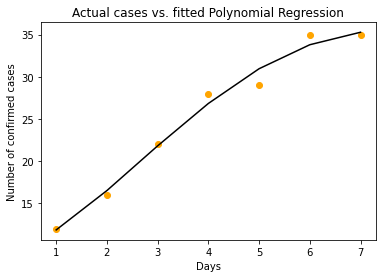

In [145]:
def viz_polymonial():
    plt.scatter(X, y, color='orange')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='black')
    plt.title('Actual cases vs. fitted Polynomial Regression')
    plt.xlabel('Days')
    plt.ylabel('Number of confirmed cases')
    plt.show()
    return
viz_polymonial()

In [146]:
now = datetime.now() # current date and time

Now = now.strftime("%Y%m%d_%Hh%M")

Pred_Data.to_csv(f'C:\\Users\\JMSch\\Desktop\\COVID19\\Data\\Extracts\\Polynomial_Prediction_Output_Global_{Now}.csv', index = False)